# Clustering of drawn components in galaxy builder

### Problem:

*Given a set of ellipses and rotated rectangles (in zooniverse coordinates), how do we recover one aggregate shape for each task?*

First, say the jupyter magic words 🧙‍

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import the plethora of useful modules we'll need (including some we probably don't)

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import requests
from PIL import Image
from shapely.geometry import MultiPolygon
from shapely.affinity import scale, translate
from descartes import PolygonPatch
import lib.galaxy_utilities as gu
import gzbuilder_analysis.aggregation as ag
import gzbuilder_analysis.parsing as pg
from IPython import display
from asinh_cmap import asinh_cmap_r

/Users/tlingard/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
# from gzbuilder_analysis.fitting import jax as fj

In [4]:
font = {'family' : 'DejaVu Sans',
        'size'   : 16}

matplotlib.rc('font', **font)

Which subject should we work on? (parametrised to allow batch running at a later date)

In [5]:
subject_id = 20902040

In [6]:
gal_df = pd.read_csv('lib/gal-metadata.csv', index_col=0)

In [7]:
fitting_metadata = pd.read_pickle('lib/fitting_metadata.pkl')\
    .loc[subject_id]
data = fitting_metadata.galaxy_data
psf = fitting_metadata.psf
sigma_image = fitting_metadata.sigma_image

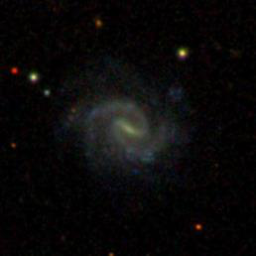

In [8]:
s = 'http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?TaskName=Skyserver.Chart.Navi&ra={}&dec={}&scale=0.396&width={}&height={}&opt='
im = Image.open(
    requests.get(
        s.format(*gal_df.loc[subject_id][['RA', 'DEC']].values, *np.array(data.shape)),
        stream=True
    ).raw
)
im.resize((256, 256), Image.HAMMING)

Grab the galaxy data (and classification data) for this galaxy

In [9]:
print('Getting galaxy data')
gal = gu.get_galaxy(subject_id)
pic_array = np.array(gu.get_image(subject_id))
zoo_im_shape = np.array(pic_array.shape)
cls_for_subject = gu.classifications.query(
    'subject_ids == {}'.format(subject_id)
)
print('Found {} classifications for subject_id {}'.format(
    len(cls_for_subject),
    subject_id,
))

Getting galaxy data
Found 32 classifications for subject_id 20902040


Convert these annnotations into models

In [10]:
zoo_models = cls_for_subject.apply(
    pg.parse_classification,
    axis=1,
    image_size=zoo_im_shape,
    size_diff=fitting_metadata['size_diff'],
    ignore_scale=True  # ignore scale slider when aggregating
)

Scale them into Sloan pixels (and apply a rotation correction if needed):

In [11]:
scaled_models = zoo_models.apply(
    pg.scale_model,
    args=(fitting_metadata['size_diff'],),
)
rotated_models = scaled_models.apply(
    pg.rotate_model_about_centre,
    args=(zoo_im_shape*fitting_metadata['size_diff'], fitting_metadata.rotation_correction,),
)

We also reproject them to their original WCS (rather than the WCS calculated by `Montage`)

In [12]:
models = rotated_models.apply(
    pg.reproject_model,
    wcs_in=fitting_metadata['montage_wcs'],
    wcs_out=fitting_metadata['original_wcs']
)

In [13]:
print('Received {} classifications'.format(len(models)))
print('\t{} disks'.format(
    len(models.apply(lambda m: m.get('disk', False)).dropna())
))
print('\t{} bulges'.format(
    len(models.apply(lambda m: m.get('bulge', False)).dropna())
))
print('\t{} bars'.format(
    len(models.apply(lambda m: m.get('bar', False)).dropna())
))
print('\t{} spiral arms'.format(
    models.apply(lambda m: m['spiral'].get('n_arms', 0)).sum()
))

print('\nSpiral galaxy arm number:')
print('\n'.join(
    '{: >2d} models with {:>2} spiral arm{}'.format(j, i, ('s' if i > 1 else ''))
    for i, j in models.apply(lambda m: m['spiral'].get('n_arms', 0)).value_counts().sort_index().iteritems()
))

Received 32 classifications
	28 disks
	24 bulges
	17 bars
	57 spiral arms

Spiral galaxy arm number:
 4 models with  0 spiral arm
 7 models with  1 spiral arm
14 models with  2 spiral arms
 6 models with  3 spiral arms
 1 models with  4 spiral arms


We can do some preliminary cleanup of the models (i.e. enforcing rectangular bars)

In [14]:
sanitized_models = models.apply(pg.sanitize_model)

And then grab the shapely geometries corresponding to these models

In [15]:
geoms = pd.DataFrame(
    sanitized_models.apply(ag.get_geoms).values.tolist(),
    columns=('disk', 'bulge', 'bar')
)

Now let's performe the aggregation.

Disks, bulges and bars are clustered using DBSCAN with the *Jaccard distance* metric:

$$D = 1 - \frac{\text{intersection area}}{\text{union area}}$$

Spirals are clustered based on a custom metric, similar to the Frechet distance.

Calculating the aggregation result typically takes up to one minute, with most time being spent clustering and cleaning the spiral arms.

In [16]:
# %%time
# aggregation_result = ag.AggregationResult(sanitized_models, data)

We'll load in a model for convenience here

In [17]:
try:
    aggregation_result = pd.read_pickle(f'output_files/aggregation_results/{subject_id}.pkl.gz')
except FileNotFoundError:
    aggregation_result = ag.AggregationResult(sanitized_models, data)

In [18]:
disk_cluster_geoms = aggregation_result.clusters['disk'].apply(ag.make_ellipse)
bulge_cluster_geoms = aggregation_result.clusters['bulge'].apply(ag.make_ellipse)
bar_cluster_geoms = aggregation_result.clusters['bar'].apply(ag.make_box)
drawn_arms = ag.spirals.get_drawn_arms(sanitized_models)
arms = aggregation_result.spiral_arms

## Plotting for method paper

Define some useful goodies for plotting later (to transform from image coordinates to arcseconds from centre of galaxy)

In [19]:
def transform_patch(p, s=2):
    corrected_patch = scale(
        translate(p, xoff=-data.shape[1]/2, yoff=-data.shape[0]/2),
        xfact=0.396,
        yfact=0.396,
        origin=(0, 0),
    )
#     display patch at s*Re
    return scale(corrected_patch, s, s)

def transform_arm(arm):
    return (arm - np.array(data.shape) / 2)* 0.396

extent = (np.array([[-1, -1],[1, 1]]) * data.shape).T.ravel() / 2 * 0.396
imshow_kwargs = {
    'cmap': asinh_cmap_r, 'origin': 'lower',
    'extent': extent
}

Let's see the drawn shapes overlaid on the galaxy:

In [20]:
from astropy.visualization import AsinhStretch
s = AsinhStretch()

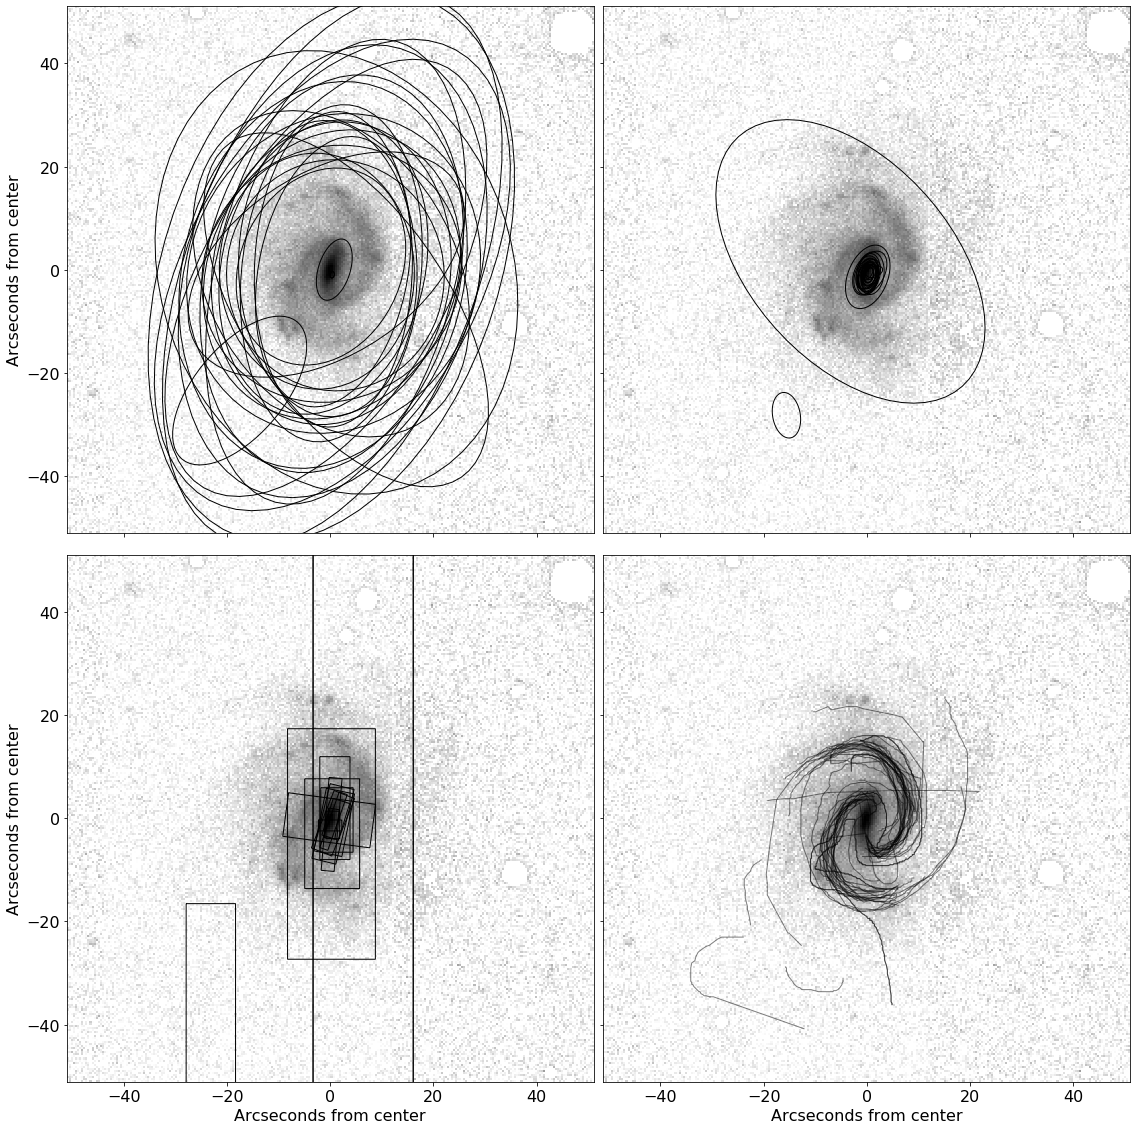

In [21]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    ncols=2, nrows=2,
    figsize=(16, 16),
    sharex=True, sharey=True
)
ax0.imshow(s(data), **imshow_kwargs)
for comp in geoms['disk'].values:
    if comp is not None:
        ax0.add_patch(
            PolygonPatch(transform_patch(comp), fc='none', ec='k',
                         zorder=3)
        )
ax1.imshow(s(data), **imshow_kwargs)
for comp in geoms['bulge'].values:
    if comp is not None:
        ax1.add_patch(
            PolygonPatch(transform_patch(comp), fc='none', ec='k',
                         zorder=3)
        )
ax2.imshow(s(data), **imshow_kwargs)
for comp in geoms['bar'].values:
    if comp is not None:
        ax2.add_patch(
            PolygonPatch(transform_patch(comp), fc='none', ec='k',
                         zorder=3)
        )
ax3.imshow(s(data), **imshow_kwargs)
for arm in drawn_arms:
    ax3.plot(*transform_arm(arm).T, 'k', alpha=0.5, linewidth=1)

for i, ax in enumerate((ax0, ax1, ax2, ax3)):
    ax.set_xlim(imshow_kwargs['extent'][:2])
    ax.set_ylim(imshow_kwargs['extent'][2:])
    if i % 2 == 0:
        ax.set_ylabel('Arcseconds from center')
    if i > 1:
        ax.set_xlabel('Arcseconds from center')
fig.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
plt.savefig('method-paper-plots/drawn_shapes.pdf', bbox_inches='tight')

Our resulting clusters look like this: (empty sub-plot means no cluster)

In [22]:
[print('Clustered {1} {0}s'.format(k, len(v))) for k, v in aggregation_result.clusters.items()];
print([len(a.arms) for a in aggregation_result.spiral_arms])

Clustered 21 disks
Clustered 11 bulges
Clustered 4 bars
[14, 13]


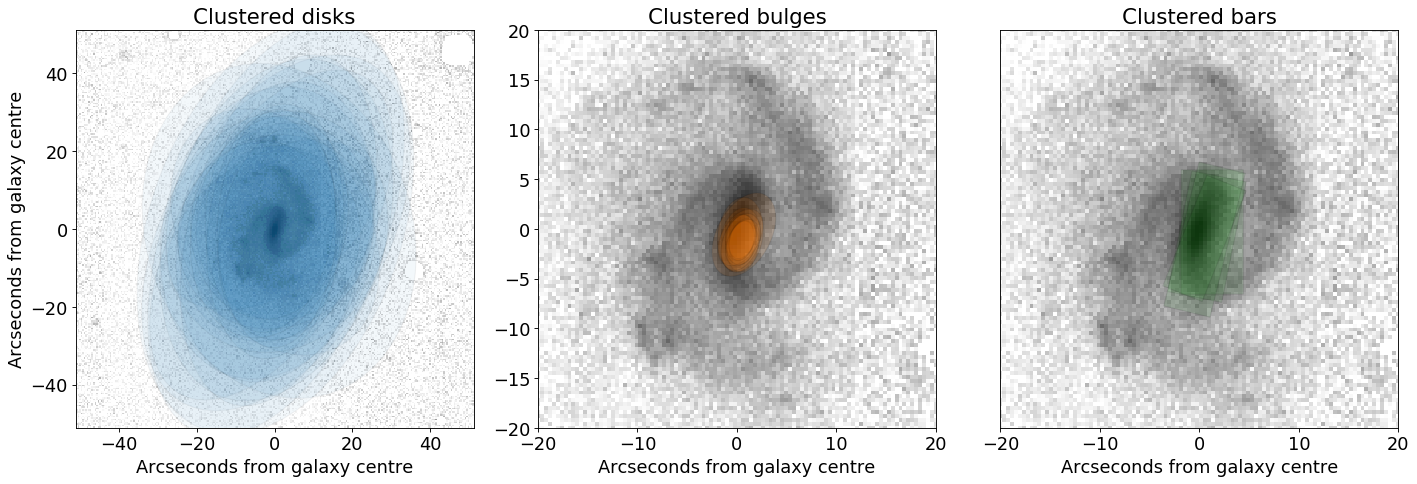

In [23]:
fig = plt.figure(1, figsize=(18, 6), dpi=80)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplot(131)
plt.imshow(s(data), **imshow_kwargs)
for disk in disk_cluster_geoms:
    p = PolygonPatch(transform_patch(disk), fc='C0', ec='k', alpha=0.05, zorder=2)
    plt.gca().add_patch(p)
plt.title('Clustered disks')
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')

plt.subplot(132)
plt.imshow(s(data), **imshow_kwargs)
for bulge in bulge_cluster_geoms:
    p = PolygonPatch(transform_patch(bulge), fc='C1', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
# plt.yticks([])
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.title('Clustered bulges')
plt.xlabel('Arcseconds from galaxy centre')

plt.subplot(133)
plt.imshow(s(data), **imshow_kwargs)
for bar in bar_cluster_geoms:
    p = PolygonPatch(transform_patch(bar), fc='C2', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
plt.yticks([])
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.title('Clustered bars')
plt.xlabel('Arcseconds from galaxy centre')
plt.tight_layout()
plt.savefig('method-paper-plots/clustered_shapes.pdf', bbox_inches='tight')

# Aggregate model

And the resulting aggregate shapes like this:

In [43]:
print('Defining helper function')
try:
    agg_disk_geom = ag.make_ellipse(aggregation_result.model.disk.to_dict())
except AttributeError:
    agg_disk_geom = None
try:
    agg_bulge_geom = ag.make_ellipse(aggregation_result.model.bulge.to_dict())
except AttributeError:
    agg_bulge_geom = None
try:
    agg_bar_geom = ag.make_box(aggregation_result.model.bar.to_dict())
except AttributeError:
    agg_bar_geom = None

def make_patches(c=('C0', 'C1', 'C2'), ls=('-.', ':', '--'), **kwargs):
    k = { 'alpha': 0.3, 'zorder': 3, 'ec': 'k', **kwargs}
    patches = [
        PolygonPatch(
            transform_patch(geom),
            fc=c[i],
            linestyle=ls[i],
            **k,
        ) if geom is not None else None
        for i, geom in enumerate(
            (agg_disk_geom, agg_bulge_geom, agg_bar_geom)
        )
    ]
    return patches

Defining helper function


In [44]:
disk_crop = min(np.abs(imshow_kwargs['extent']).min(), 1000)
bulge_crop = bar_crop = min(np.abs(imshow_kwargs['extent']).min(), 15)
spiral_crop = min(np.abs(imshow_kwargs['extent']).min(), 25)

In [45]:
# fig = plt.figure(1, figsize=(18, 6))
# plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

# edge_patches = make_patches(
#     c=('none', 'none', 'none'),
#     alpha=1,
#     lw=4,
# )
# face_patches = make_patches(
#     c=('C0', 'C1', 'C2'),
#     ec='none'
# )

# plt.subplot(131)
# plt.imshow(s(data), **imshow_kwargs)
# for disk in disk_cluster_geoms:
#     p = PolygonPatch(transform_patch(disk), fc='none', ec='k', alpha=0.5, zorder=2)
#     plt.gca().add_patch(p)
# try:
#     plt.gca().add_patch(edge_patches[0])
#     plt.gca().add_patch(face_patches[0])
# except AttributeError:
#     pass
# plt.title('Aggregate disk')
# plt.xlabel('Arcseconds from galaxy centre')
# plt.ylabel('Arcseconds from galaxy centre')
# plt.xlim(-disk_crop, disk_crop)
# plt.ylim(-disk_crop, disk_crop)


# plt.subplot(132)
# plt.imshow(s(data), **imshow_kwargs)
# for bulge in bulge_cluster_geoms:
#     p = PolygonPatch(transform_patch(bulge), fc='none', ec='k', alpha=0.5, zorder=2)
#     plt.gca().add_patch(p)
# try:
#     plt.gca().add_patch(edge_patches[1])
#     plt.gca().add_patch(face_patches[1])

# except AttributeError:
#     pass
# plt.title('Aggregate bulge')
# plt.xlabel('Arcseconds from galaxy centre')
# plt.xlim(-bulge_crop, bulge_crop)
# plt.ylim(-bulge_crop, bulge_crop)

# plt.subplot(133)
# plt.imshow(s(data), **imshow_kwargs)
# for bar in bar_cluster_geoms:
#     p = PolygonPatch(transform_patch(bar), fc='none', ec='k', alpha=0.5, zorder=2)
#     plt.gca().add_patch(p)
# try:
#     plt.gca().add_patch(edge_patches[2])
#     plt.gca().add_patch(face_patches[2])

# except AttributeError:
#     pass
# plt.title('Aggregate bar')
# plt.xlabel('Arcseconds from galaxy centre')
# plt.xlim(-bar_crop, bar_crop)
# plt.ylim(-bar_crop, bar_crop)

# plt.tight_layout()
# plt.savefig('method-paper-plots/mean_shapes.pdf', bbox_inches='tight')

What points have been thrown away from the spiral arms?

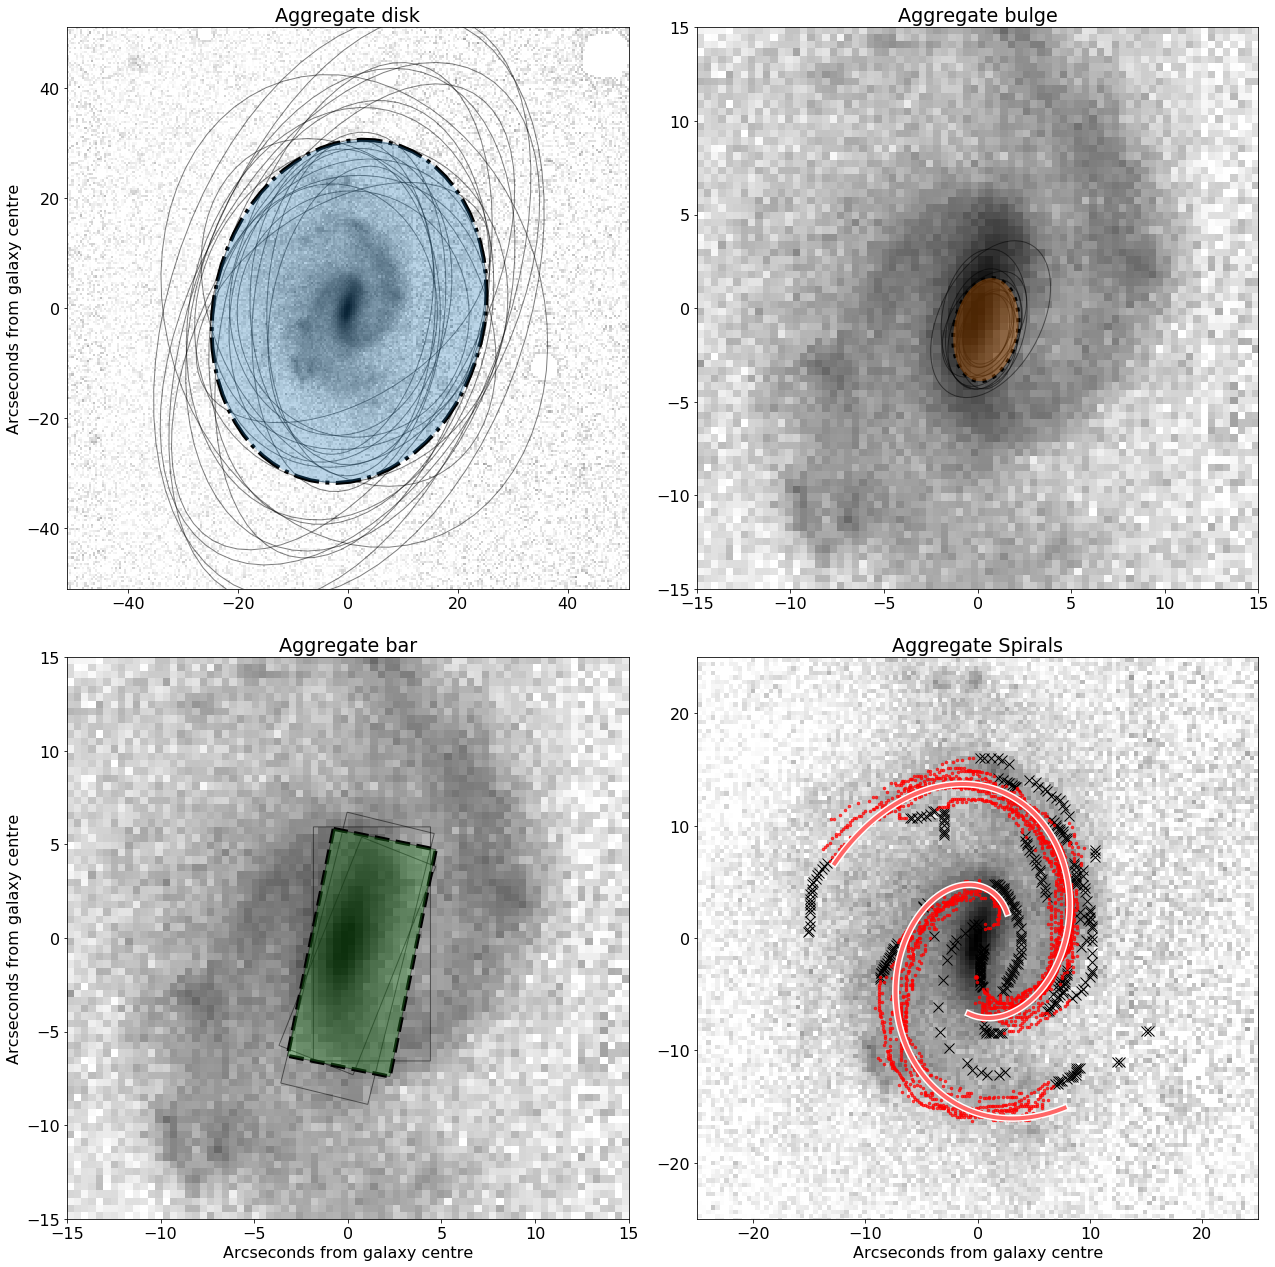

In [46]:
fig = plt.figure(1, figsize=(18, 18))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

edge_patches = make_patches(
    c=('none', 'none', 'none'),
    alpha=1,
    lw=4,
)
face_patches = make_patches(
    c=('C0', 'C1', 'C2'),
    ec='none'
)

plt.subplot(221)
plt.imshow(s(data), **imshow_kwargs)
for disk in disk_cluster_geoms:
    p = PolygonPatch(transform_patch(disk), fc='none', ec='k', alpha=0.5, zorder=2)
    plt.gca().add_patch(p)
try:
    plt.gca().add_patch(edge_patches[0])
    plt.gca().add_patch(face_patches[0])
except AttributeError:
    pass
plt.title('Aggregate disk')
# plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')
plt.xlim(-disk_crop, disk_crop)
plt.ylim(-disk_crop, disk_crop)


plt.subplot(222)
plt.imshow(s(data), **imshow_kwargs)
for bulge in bulge_cluster_geoms:
    p = PolygonPatch(transform_patch(bulge), fc='none', ec='k', alpha=0.5, zorder=2)
    plt.gca().add_patch(p)
try:
    plt.gca().add_patch(edge_patches[1])
    plt.gca().add_patch(face_patches[1])

except AttributeError:
    pass
plt.title('Aggregate bulge')
# plt.ylabel('Arcseconds from galaxy centre')
plt.xlim(-bulge_crop, bulge_crop)
plt.ylim(-bulge_crop, bulge_crop)

plt.subplot(223)
plt.imshow(s(data), **imshow_kwargs)
for bar in bar_cluster_geoms:
    p = PolygonPatch(transform_patch(bar), fc='none', ec='k', alpha=0.5, zorder=2)
    plt.gca().add_patch(p)
try:
    plt.gca().add_patch(edge_patches[2])
    plt.gca().add_patch(face_patches[2])
except AttributeError:
    pass
plt.title('Aggregate bar')
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')
plt.xlim(-bar_crop, bar_crop)
plt.ylim(-bar_crop, bar_crop)

plt.subplot(224)
plt.imshow(s(data), **imshow_kwargs)
for i, arm in enumerate(arms):
    plt.plot(*transform_arm(arm.coords[~arm.outlier_mask]).T, 'kx', markersize=10)
    plt.plot(*transform_arm(arm.coords[arm.outlier_mask]).T, '.', c=f'r', markersize=5, alpha=0.7)
    plt.plot(*transform_arm(arm.reprojected_log_spiral).T, c=f'w', lw=7)
    plt.plot(*transform_arm(arm.reprojected_log_spiral).T, c=f'r', lw=4, alpha=0.6)
plt.title('Aggregate Spirals')
plt.xlabel('Arcseconds from galaxy centre')
plt.xlim(-spiral_crop, spiral_crop)
plt.ylim(-spiral_crop, spiral_crop)
plt.tight_layout()
plt.savefig('method-paper-plots/mean_shapes.pdf', bbox_inches='tight')


And finally, let's see our resulting galaxy model

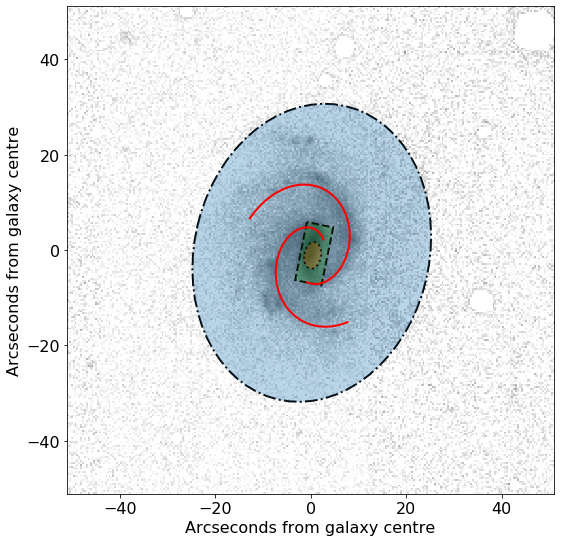

In [47]:
edge_patches = make_patches(
    c=('none', 'none', 'none'),
    alpha=1,
    lw=2,
)
face_patches = make_patches(
    ec='none',
)
plt.figure(figsize=(8,8))
plt.imshow(s(data), **imshow_kwargs)
try:
    plt.gca().add_patch(edge_patches[0])
    plt.gca().add_patch(face_patches[0])
except AttributeError:
    pass
try:
    plt.gca().add_patch(edge_patches[2])
    plt.gca().add_patch(face_patches[2])

except AttributeError:
    pass
try:
    plt.gca().add_patch(edge_patches[1])
    plt.gca().add_patch(face_patches[1])

except AttributeError:
    pass
  
for arm in arms:
    a = transform_arm(arm.reprojected_log_spiral)
    plt.plot(*a.T, 'r', lw=2, zorder=4)


plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')
plt.xlim(-disk_crop, disk_crop)
plt.ylim(-disk_crop, disk_crop)

plt.tight_layout()
plt.savefig('method-paper-plots/aggregate_model.pdf', bbox_inches='tight')

And there we have it! A complex model of SDSS r-band data, performed using citizen science, where we can now fine-tune parameters using gradient descent!

We can plot the result of fitting:

In [29]:
fit_model = pd.read_pickle(f'output_files/tuning_results/{subject_id}.pickle.gz')

In [30]:
fit_model['res']

      fun: array(99031.81206842)
 hess_inv: <31x31 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.49043440e-01,  6.51116941e+01,  1.30097861e+00,  2.38935816e+00,
       -1.83527685e+00, -1.28571727e+01,  6.29360668e+01,  8.90518265e+01,
        3.42926907e+01,  3.08692723e+00, -1.43590088e+00, -4.87398324e+00,
        4.07527088e+00,  2.44068874e+00, -1.67676013e+00, -9.30855839e-02,
       -3.86103567e-01, -5.04713389e+00,  1.48633940e+01,  2.24661724e+00,
        3.01762779e-01, -1.72803148e+00,  1.83132110e+00, -2.47156425e+00,
        2.70509033e+00,  2.44373977e+00, -1.72405381e+00, -6.40875001e-02,
       -1.46086660e+00,  2.56038465e+00,  1.95159906e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 937
      nit: 833
   status: 0
  success: True
        x: array([ 4.17502126e+00,  4.95159567e-02,  9.30887253e-01,  2.26536141e-01,
        2.91679325e+00,  1.34027762e-01,  2.29769832e-02,  5.00000000e-01,
        6.12633999e-01,  2.90284

In [31]:
from gzbuilder_analysis import df_to_dict
from gzbuilder_analysis.rendering import psf_conv
from gzbuilder_analysis.rendering import get_spirals

In [32]:
final_model = df_to_dict(fit_model['deparametrized'].unstack().T)

In [33]:
n_spirals = len(final_model.get('spiral', {})) // 6

In [34]:
fit_spirals = get_spirals(fit_model['fit_model'].to_dict(), n_spirals, fit_model['fit_model'].disk.roll)

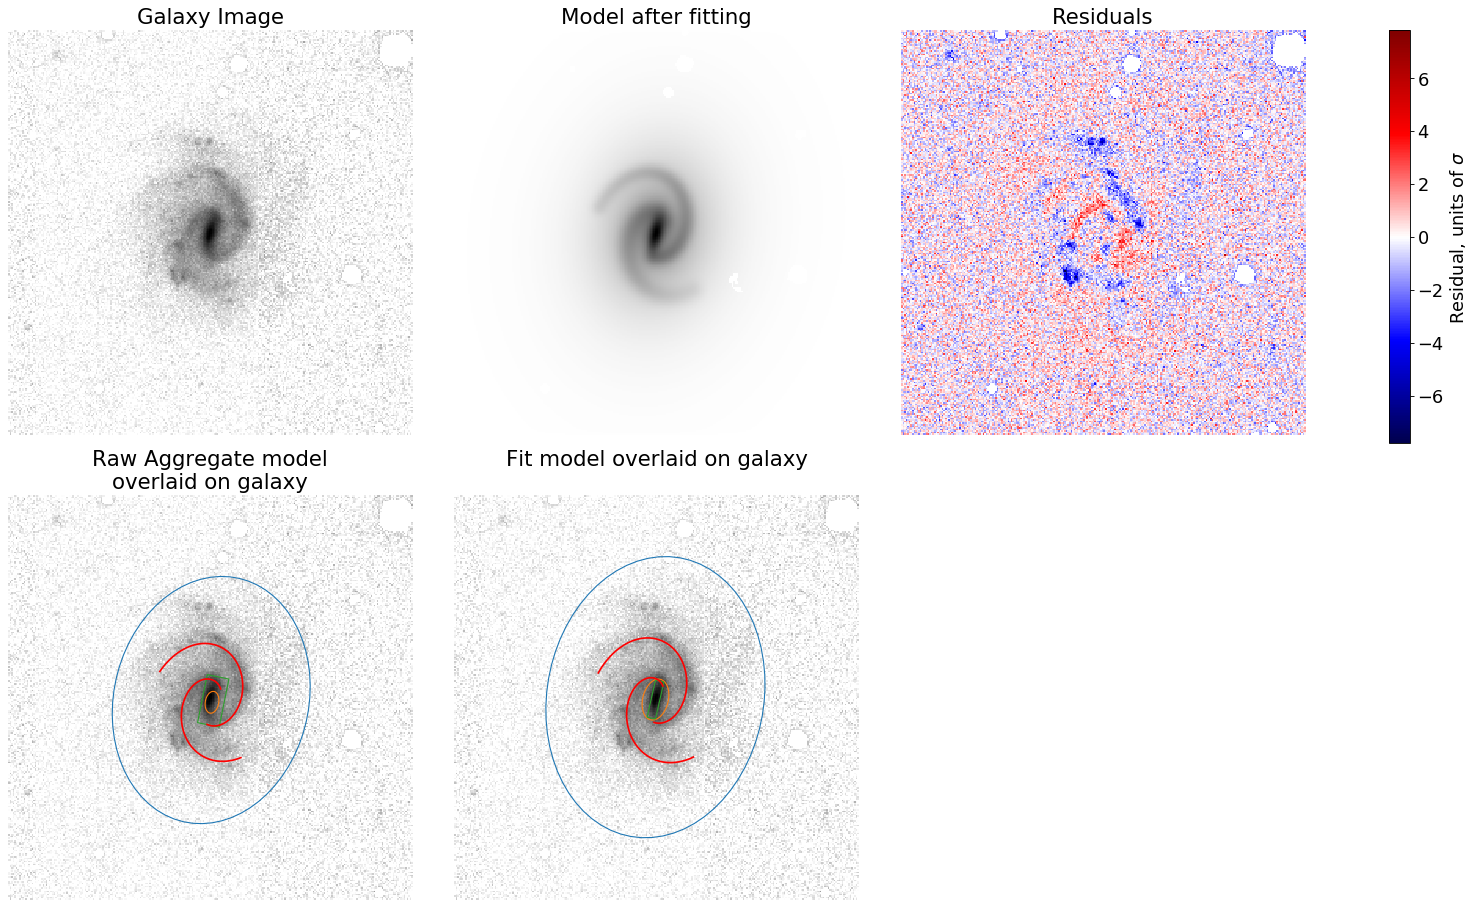

In [35]:
final_gal = np.ma.masked_array(psf_conv(sum(fit_model['comps'].values()), psf), data.mask)
s = AsinhStretch()
lm = s([
    min(np.nanmin(data), np.nanmin(final_gal)),
    max(np.nanmax(data), np.nanmax(final_gal)),
])
d = (final_gal - data) / sigma_image
l2 = np.nanmax(np.abs(d))

f, ax = plt.subplots(nrows=2, ncols=3, figsize=(15*1.8, 8.*1.8), dpi=80)
plt.subplots_adjust(wspace=0, hspace=0.15)
ax[0, 0].imshow(
    s(data),
    vmin=lm[0], vmax=lm[1], **imshow_kwargs,
)
ax[0, 1].imshow(
    s(final_gal),
    vmin=lm[0], vmax=lm[1], **imshow_kwargs,
)
ax[1, 0].imshow(
    s(data),
    vmin=lm[0], vmax=lm[1], **imshow_kwargs,
)
ax[1, 1].imshow(
    s(data),
    vmin=lm[0], vmax=lm[1], **imshow_kwargs,
)
c = ax[0][2].imshow(d, vmin=-l2, vmax=l2, cmap='seismic', origin='lower')
cbar = plt.colorbar(c, ax=ax, shrink=0.475, anchor=(0, 1))
cbar.ax.set_ylabel(r'Residual, units of $\sigma$')

# add component overlays
initial_disk = ag.make_ellipse(aggregation_result.model['disk'])
final_disk = ag.make_ellipse(final_model['disk'])

ax[1, 0].add_patch(PolygonPatch(transform_patch(initial_disk), ec='C0', fc='none'))
ax[1, 1].add_patch(PolygonPatch(transform_patch(final_disk), ec='C0', fc='none'))

if aggregation_result.model.get('bulge', None) is not None:
    initial_bulge = ag.make_ellipse(aggregation_result.model['bulge'])
    ax[1, 0].add_patch(PolygonPatch(transform_patch(initial_bulge), ec='C1', fc='none'))
if final_model.get('bulge', None) is not None:
    final_bulge = ag.make_ellipse(final_model['bulge'])
    ax[1, 1].add_patch(PolygonPatch(transform_patch(final_bulge), ec='C1', fc='none'))
    
if aggregation_result.model.get('bar', None) is not None:
    initial_bar = ag.make_box(aggregation_result.model['bar'])
    ax[1, 0].add_patch(PolygonPatch(transform_patch(initial_bar), ec='C2', fc='none'))
if final_model.get('bar', None) is not None:
    final_bar = ag.make_box(final_model['bar'])
    ax[1, 1].add_patch(PolygonPatch(transform_patch(final_bar), ec='C2', fc='none'))

for a in aggregation_result.spiral_arms:
    ax[1, 0].plot(*transform_arm(a.reprojected_log_spiral).T, 'r')

for arm in fit_spirals:
    ax[1, 1].plot(*transform_arm(arm).T, 'r')
ax[0, 0].set_title('Galaxy Image')
ax[0, 1].set_title('Model after fitting')
ax[0, 2].set_title('Residuals')
ax[1, 0].set_title('Raw Aggregate model\noverlaid on galaxy')
ax[1, 1].set_title('Fit model overlaid on galaxy\n')
for a in ax.ravel():
    a.axis('off')
plt.savefig('method-paper-plots/model_tuning.pdf', bbox_inches='tight')

In [36]:
from IPython.display import Latex

Latex(r'$\chi_\nu^2 = {:.4f}$'.format(fit_model['chisq']))

<IPython.core.display.Latex object>

Another possible way of viewing the fit is by subtracting components sequentially:

In [37]:
multiplier = fitting_metadata.multiplier

{'vmin': -1.1699218991892444, 'vmax': 1.1699218991892444}


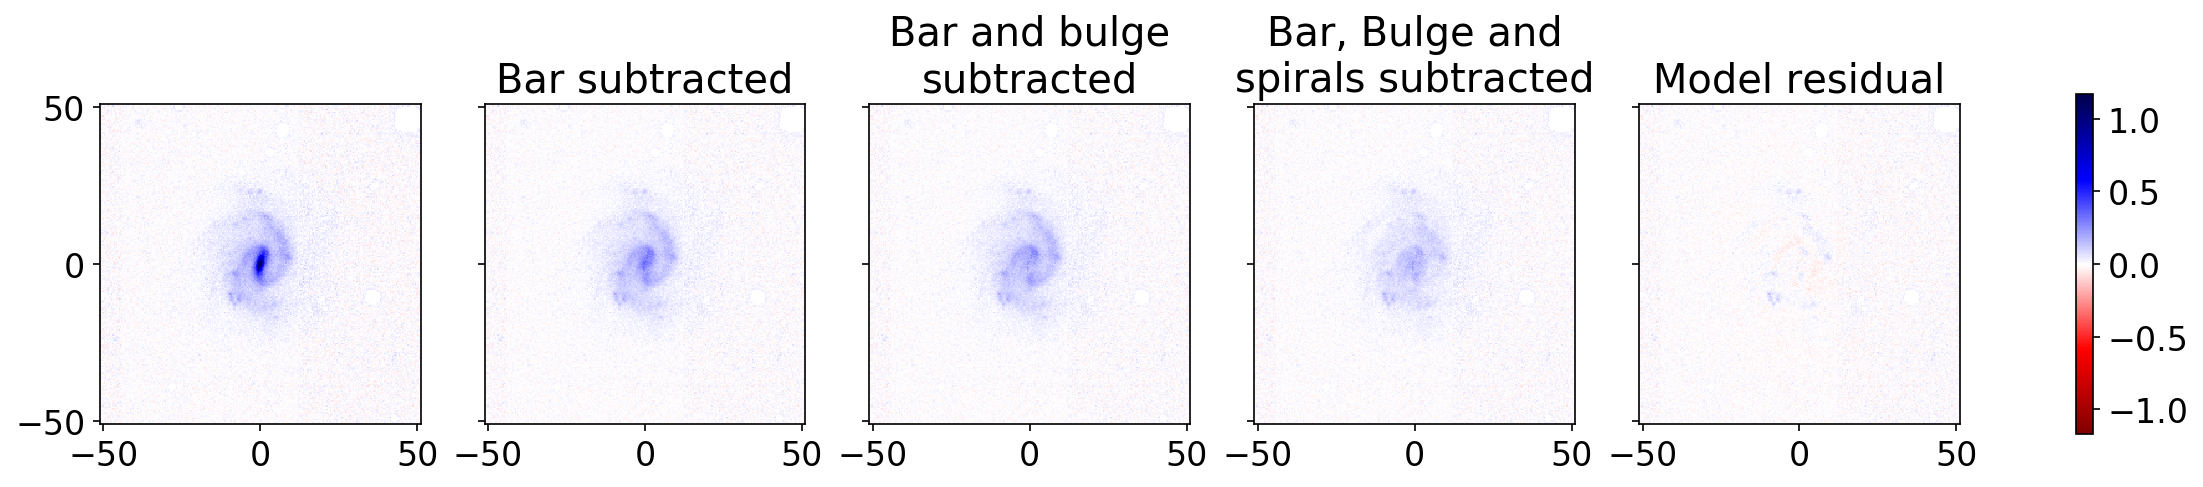

In [38]:
comps = fit_model['comps']

def _get_residual(components_to_include='all'):
    if components_to_include == 'all':
        components_to_include = comps.keys()
    return data - np.array(psf_conv(sum(comps.get(c, z) for c in components_to_include), psf))

z = np.zeros_like(comps['disk'])
f, ax = plt.subplots(ncols=5, figsize=(20, 6), dpi=150, sharey=True)
vm = dict(vmin=-np.abs(multiplier * data).max(), vmax=np.abs(multiplier * data).max())
print(vm)
imshow_kwargs2 = {**imshow_kwargs, 'cmap': 'seismic_r', **vm}
im = ax[0].imshow(multiplier * data, **imshow_kwargs2)
ax[1].imshow(_get_residual(components_to_include=['bar']), **imshow_kwargs2)
ax[1].set_title('Bar subtracted')
ax[2].imshow(_get_residual(components_to_include=['bar', 'bulge']), **imshow_kwargs2)
ax[2].set_title('Bar and bulge\nsubtracted')
ax[3].imshow(_get_residual(components_to_include=['bar', 'bulge', 'spiral']), **imshow_kwargs2)
ax[3].set_title('Bar, Bulge and\nspirals subtracted')
ax[4].imshow(_get_residual(components_to_include='all'), **imshow_kwargs2)
ax[4].set_title('Model residual')
plt.colorbar(im, ax=ax, shrink=0.5)